In [247]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder
import sklearn.metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import GridSearchCV

In [2]:
sns.set_style("whitegrid")
sns.set_context("notebook")
sns.set_palette("RdBu")

## 1. Import training data

In [3]:
data = pd.read_csv("bike_train.csv", parse_dates=["datetime"])

In [4]:
data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


## 2. Data integrity check

In [5]:
# check for missing data
data.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [6]:
# check for data size, column number and types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [7]:
# check statistical summary of numerical columns
data.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [8]:
# convert season and weather columns to categorical columns
# for season we can replace the number with the name of the season for better readability and visualization

data.replace({'season':{1:'spring', 2:'summer', 3:'fall', 4:'winter'}}, inplace=True)

# do the same for weather

data.replace({'weather':{1:'clear', 2:'cloudy', 3:'rainy', 4:'heavy_rain'}}, inplace=True)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  object        
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  object        
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(6), object(2)
memory usage: 1020.7+ KB


In [10]:
data.describe(include='O')

,season,weather
count,10886,10886
unique,4,4
top,winter,clear
freq,2734,7192


In [11]:
print(data['season'].value_counts())
print(data['weather'].value_counts())

winter    2734
fall      2733
summer    2733
spring    2686
Name: season, dtype: int64
clear         7192
cloudy        2834
rainy          859
heavy_rain       1
Name: weather, dtype: int64


## 3. Extracting date and time features from datetime stamp

In [12]:
data['year'] = data['datetime'].dt.year
print(data['year'].value_counts(normalize=True).sort_index())

data['month'] = data['datetime'].dt.month
print(data['month'].value_counts(normalize=True).sort_index())

data['day_week'] = data['datetime'].dt.dayofweek
data['day_name'] = data['datetime'].dt.day_name()
print(data['day_week'].value_counts(normalize=True).sort_index())
print(data['day_name'].value_counts(normalize=True).sort_index())


data['hour'] = data['datetime'].dt.hour
print(data['hour'].value_counts(normalize=True).sort_index())

2011    0.498071
2012    0.501929
Name: year, dtype: float64
1     0.081205
2     0.082767
3     0.082767
4     0.083502
5     0.083777
6     0.083777
7     0.083777
8     0.083777
9     0.083502
10    0.083685
11    0.083685
12    0.083777
Name: month, dtype: float64
0    0.142477
1    0.141374
2    0.142477
3    0.142660
4    0.140456
5    0.145508
6    0.145049
Name: day_week, dtype: float64
Friday       0.140456
Monday       0.142477
Saturday     0.145508
Sunday       0.145049
Thursday     0.142660
Tuesday      0.141374
Wednesday    0.142477
Name: day_name, dtype: float64
0     0.041797
1     0.041705
2     0.041154
3     0.039776
4     0.040603
5     0.041521
6     0.041797
7     0.041797
8     0.041797
9     0.041797
10    0.041797
11    0.041797
12    0.041889
13    0.041889
14    0.041889
15    0.041889
16    0.041889
17    0.041889
18    0.041889
19    0.041889
20    0.041889
21    0.041889
22    0.041889
23    0.041889
Name: hour, dtype: float64


## 4. Feature Engineering

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  object        
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  object        
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
 12  year        10886 non-null  int64         
 13  month       10886 non-null  int64         
 14  day_week    10886 non-null  int64         
 15  day_name    10886 non-null  object        
 16  hour        10886 non-

### 4.1 Handling Ouliers

In [14]:
cont_vars = ['temp', 'atemp', 'windspeed', 'humidity']
cat_vars = ['season', 'weather', 'workingday', 'holiday', 'day_name', 'month', 'year', 'hour']
targets = ['count', 'registered', 'casual']

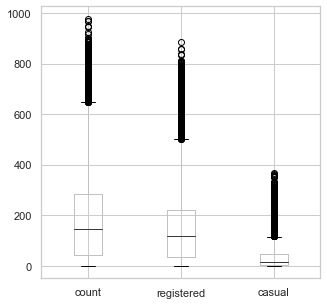

In [15]:
# do the targets have outliers ? the main target for the model is count, but it is useful to look at 
# the two components behavior as well

data[targets].boxplot(figsize=(5,5))
plt.show()

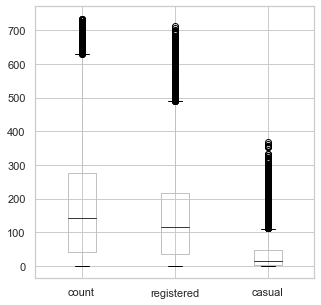

In [16]:
# there appears to be some extreme data points for count
# we can remove records/rows that are more than 3 times the std of the data for count
# this will not totally remove all outliers but only the most extreme count data records

count_std = data['count'].std()
count_mean = data['count'].mean()

# Calculate the cutoff
cut_off = count_std * 3
lower, upper = count_mean - cut_off, count_mean + cut_off

# Trim the outliers
trimmed_data = data[(data['count'] < upper) & (data['count'] > lower)].copy()

# The trimmed box plot
trimmed_data[targets].boxplot(figsize=(5,5))
plt.show()

In [17]:
trimmed_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10739 entries, 0 to 10885
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10739 non-null  datetime64[ns]
 1   season      10739 non-null  object        
 2   holiday     10739 non-null  int64         
 3   workingday  10739 non-null  int64         
 4   weather     10739 non-null  object        
 5   temp        10739 non-null  float64       
 6   atemp       10739 non-null  float64       
 7   humidity    10739 non-null  int64         
 8   windspeed   10739 non-null  float64       
 9   casual      10739 non-null  int64         
 10  registered  10739 non-null  int64         
 11  count       10739 non-null  int64         
 12  year        10739 non-null  int64         
 13  month       10739 non-null  int64         
 14  day_week    10739 non-null  int64         
 15  day_name    10739 non-null  object        
 16  hour        10739 non-

### 4.2 Binning features

In [18]:
# do some categorical features have rare values that can be grouped to other labels ?
for var in cat_vars:
    print(var)
    print(trimmed_data[var].value_counts())

season
winter    2699
summer    2694
spring    2682
fall      2664
Name: season, dtype: int64
weather
clear         7076
cloudy        2809
rainy          853
heavy_rain       1
Name: weather, dtype: int64
workingday
1    7268
0    3471
Name: workingday, dtype: int64
holiday
0    10428
1      311
Name: holiday, dtype: int64
day_name
Saturday     1582
Sunday       1578
Monday       1528
Thursday     1517
Wednesday    1514
Tuesday      1510
Friday       1510
Name: day_name, dtype: int64
month
11    911
12    910
5     901
2     901
4     898
3     897
7     896
6     895
8     888
1     884
9     880
10    878
Name: month, dtype: int64
year
2011    5422
2012    5317
Name: year, dtype: int64
hour
23    456
15    456
22    456
14    456
21    456
13    456
20    456
16    455
9     455
10    455
11    455
19    455
6     455
7     455
0     455
12    454
1     454
5     452
2     448
4     442
8     435
3     433
18    400
17    389
Name: hour, dtype: int64


In [19]:
# there is only one instance of heavy_rain in weather that can be grouped to rainy label

trimmed_data.replace({'weather': {'heavy_rain':'rainy'}}, inplace=True)
trimmed_data['weather'].value_counts()

clear     7076
cloudy    2809
rainy      854
Name: weather, dtype: int64

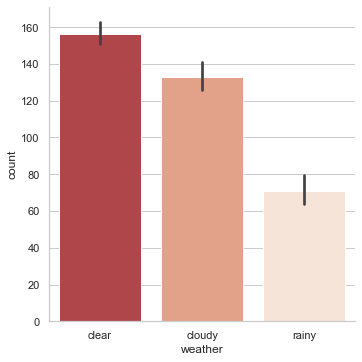

In [20]:
sns.catplot(x='weather', y='count', data=trimmed_data, estimator=np.median, kind='bar')
plt.show()

In [21]:
# clearly there is a drastic difference between clear the cloudy labels and the rainy label
# we can add a binary feature here is_rainy
trimmed_data.loc[trimmed_data['weather']=='rainy', 'is_rainy'] = 1
trimmed_data.loc[trimmed_data['weather']!='rainy', 'is_rainy'] = 0
trimmed_data['is_rainy'].value_counts()

0.0    9885
1.0     854
Name: is_rainy, dtype: int64

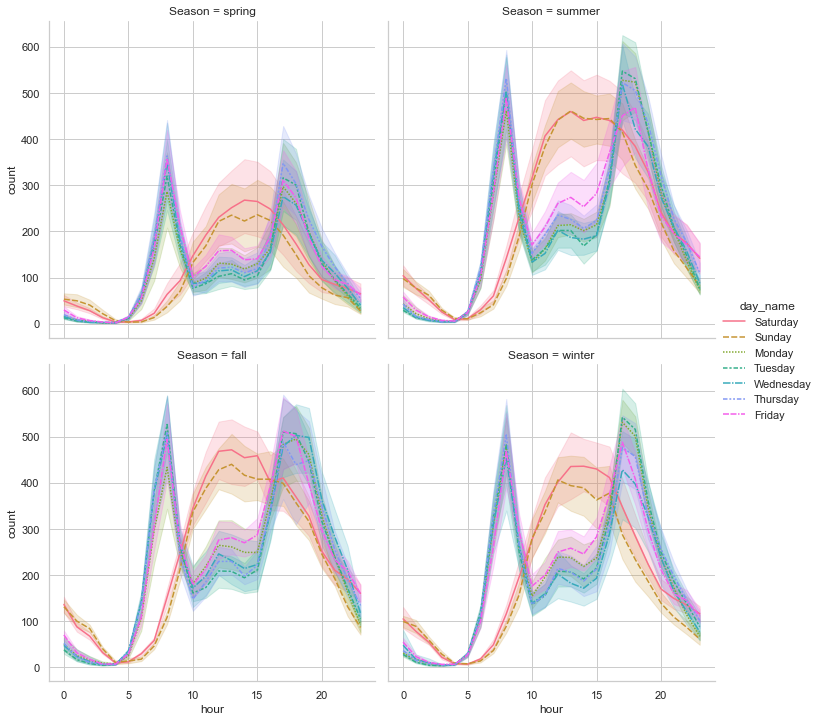

In [22]:
# taking a look at how the count changes, on average, over the hours of a day over the days of the week
# and in the different seasons

g=sns.relplot(x="hour", y="count", data=trimmed_data, kind="line", style="day_name", hue="day_name", col="season", 
            col_wrap= 2 ,markers=False, dashes=True)
g.set_titles("Season = {col_name}")
plt.show()


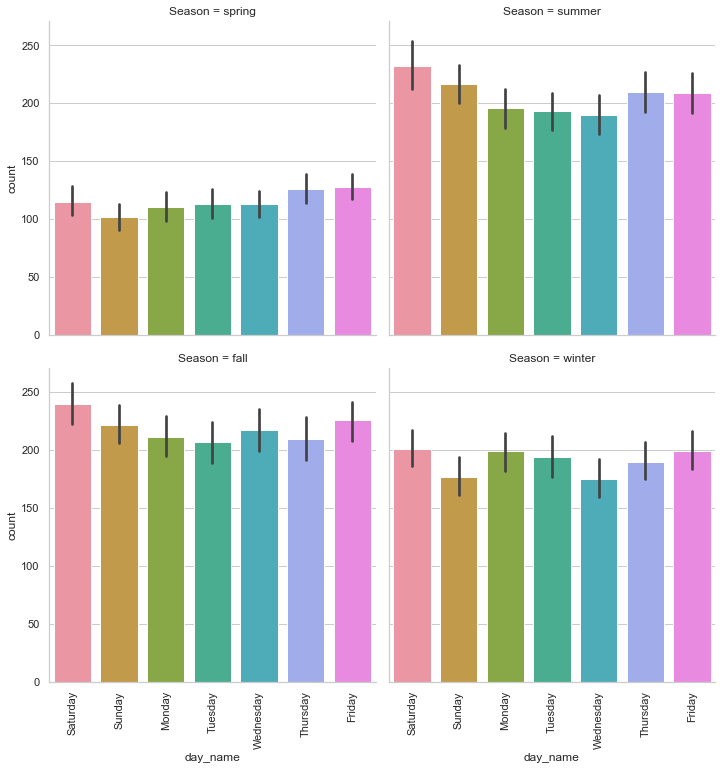

In [23]:
# taking a look at how the count changes, on average, over the days of the week
# and in the different seasons

g=sns.catplot(x="day_name", y="count", data=trimmed_data, kind="bar", col="season", col_wrap= 2)
g.set_titles("Season = {col_name}")
g.set_xticklabels(rotation=90)
plt.show()


In [24]:
# there is not a specific day that stands out to be particularly bad in all the seasons 
# But the hourly mean shows a trend in weekdays with two spikes in typical rush hours (morning and afternoon)
# while in the weekends it is different and more gausssian
# we can divide the hours into 4 groups that would capture both trends

bins = [-np.inf, 6, 12, 18, np.inf]

labels = ['night', 'morning', 'afternoon', 'evening']

trimmed_data['day_period'] = pd.cut(trimmed_data['hour'],bins=bins, labels=labels)

In [25]:
trimmed_data['day_period'].value_counts()

night        3139
morning      2709
afternoon    2612
evening      2279
Name: day_period, dtype: int64

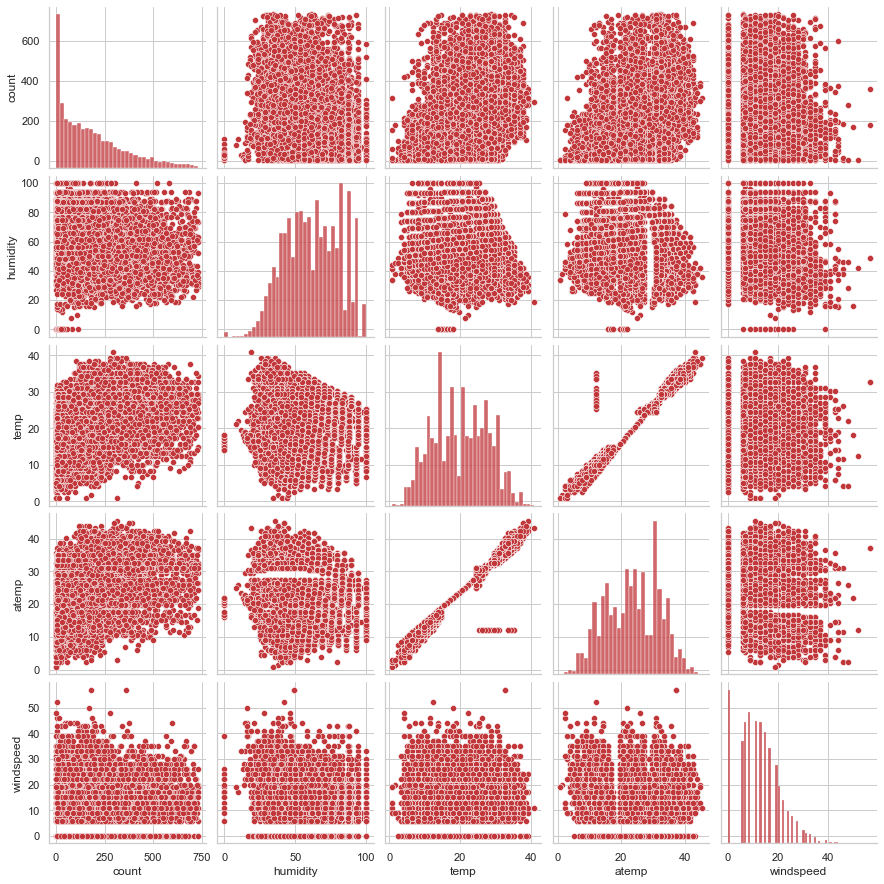

In [27]:
# plotting distributions and pairwise plots with count and continuous features

sns.pairplot(trimmed_data[['count', 'humidity', 'temp', 'atemp', 'windspeed']])
plt.show()

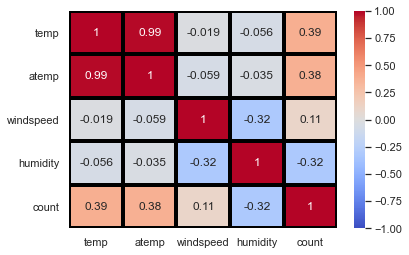

In [68]:
# let's take a look at how count is correlated with the continuous variables
# temp and atemp are highly correlated and have the same correlation with count, so we use only temp in the model
sns.heatmap(trimmed_data[cont_vars+['count']].corr(), annot = True, fmt='.2g', vmin=-1, vmax=1, center= 0, 
            cmap= 'coolwarm', linewidths=3, linecolor='black')
plt.show()

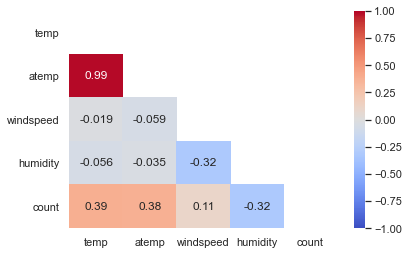

In [74]:
# we display the heatmap with no repeated cells
matrix = np.triu(trimmed_data[cont_vars+['count']].corr()) # takes the upper triangle of the correlation matrix
sns.heatmap(trimmed_data[cont_vars+['count']].corr(), annot=True, mask=matrix, fmt='.2g', 
            vmin=-1, vmax=1, center= 0, 
            cmap= 'coolwarm')
plt.show()

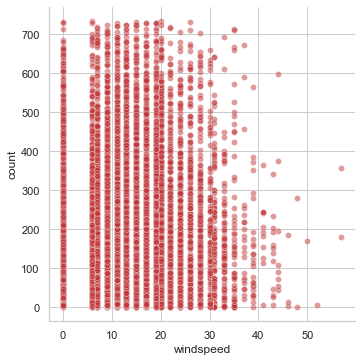

In [29]:
# taking a closer look at windspeed
sns.relplot(x='windspeed', y='count', kind='scatter', alpha=0.5, data=trimmed_data)
plt.show()

In [57]:
labels = ['low_wind', 'moderate_wind', 'high_wind']
bins = [-np.inf, 10, 30, np.inf]

trimmed_data['windspeed_binned'] = pd.cut(trimmed_data['windspeed'], bins=bins, labels=labels)

trimmed_data['windspeed_binned'].value_counts()

moderate_wind    6019
low_wind         4299
high_wind         421
Name: windspeed_binned, dtype: int64

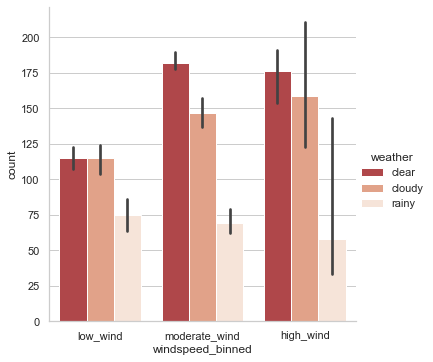

In [59]:
sns.catplot(x='windspeed_binned', y='count', hue='weather', kind='bar', data=trimmed_data, estimator=np.median)
plt.show()

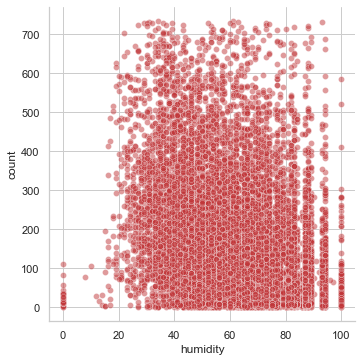

In [60]:
# # taking a closer look at humidity
sns.relplot(x='humidity', y='count', kind='scatter', alpha=0.5, data=trimmed_data)
plt.show()

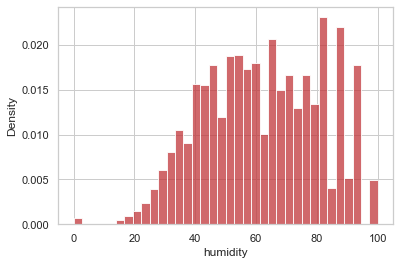

In [77]:
sns.histplot(x='humidity', data=trimmed_data, stat='density')
plt.show()

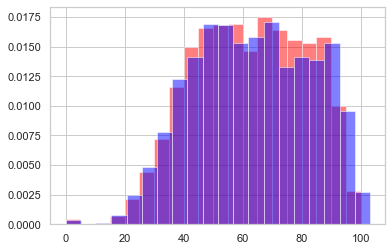

In [86]:
# humidity is moderately correlated with count and with windspeed
# it's distribution is skewed, so we can transform it
# the result did not offer much change so we can leave humidity as is
pow_trans = PowerTransformer(standardize=False)
pow_trans.fit(trimmed_data[['humidity']])
trimmed_data['humidity_trans'] = pow_trans.transform(trimmed_data[['humidity']])

fig, ax = plt.subplots()
ax.hist(x=trimmed_data['humidity'], density=True, color='r', alpha=0.5, bins=20)
ax.hist(x=trimmed_data['humidity_trans'], density=True, color='b', alpha=0.5, bins=20)

plt.show()

## 5. Baseline model


In [87]:
trimmed_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10739 entries, 0 to 10885
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   datetime          10739 non-null  datetime64[ns]
 1   season            10739 non-null  object        
 2   holiday           10739 non-null  int64         
 3   workingday        10739 non-null  int64         
 4   weather           10739 non-null  object        
 5   temp              10739 non-null  float64       
 6   atemp             10739 non-null  float64       
 7   humidity          10739 non-null  int64         
 8   windspeed         10739 non-null  float64       
 9   casual            10739 non-null  int64         
 10  registered        10739 non-null  int64         
 11  count             10739 non-null  int64         
 12  year              10739 non-null  int64         
 13  month             10739 non-null  int64         
 14  day_week          1073

In [91]:
# we will start by using a linear regression with no regularization as the baseline model

categorical_vars = ['season', 'weather', 'windspeed_binned', 'year', 'day_name', 'day_period']
numeric_vars = ['temp',   'humidity']
binary_vars = ['holiday', 'workingday', 'is_rainy']

X = trimmed_data[categorical_vars+numeric_vars+binary_vars]
y = trimmed_data['count']

preprocessor = ColumnTransformer(transformers=[
        ('numeric', StandardScaler() , numeric_vars),
        ('categorical', OneHotEncoder(handle_unknown='ignore'), categorical_vars),
        ('binary', 'passthrough', binary_vars)])

In [93]:
pipeline = Pipeline([
     ('preprocessor', preprocessor),
     ('reg', LinearRegression())])

In [163]:
pipeline.fit(X, y)
pipeline.score(X, y)

scores = cross_val_score(pipeline, X, y, cv=3, scoring='r2')

print(scores.mean())
print(scores)

0.4723474600681305
[0.40831454 0.52920162 0.47952623]


In [106]:
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [164]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify = None)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

pipeline.score(X_test, y_test)


0.5617764098156975

In [165]:
print(r2_score(y_test, abs(y_pred)), r2_score(y_test, y_pred), np.sqrt(mean_squared_log_error(y_test, abs(y_pred))))

0.5702199916019035 0.5617764098156975 1.0376022307675004


## 6. Trying different regressors

In [166]:
dtr = DecisionTreeRegressor(max_depth=8)
pipeline_dtr = Pipeline([
     ('preprocessor', preprocessor),
     ('dtr', dtr)])

pipeline_dtr.fit(X_train, y_train)

y_pred = pipeline_dtr.predict(X_test)

pipeline_dtr.score(X_test, y_test)


0.6237745651064619

In [167]:
print(r2_score(y_test, abs(y_pred)), r2_score(y_test, y_pred), np.sqrt(mean_squared_log_error(y_test, y_pred)))

0.6237745651064619 0.6237745651064619 0.7953862090233224


In [169]:
pipeline_dtr.score(X_train, y_train)

0.6679953981917554

In [181]:
dtr = DecisionTreeRegressor(max_depth=8)
pipeline_dtr = Pipeline([
     ('preprocessor', preprocessor),
     ('dtr', dtr)])

scores = - cross_val_score(pipeline_dtr, X, y, cv=5, scoring='neg_mean_squared_log_error')
scores = scores**0.5
print(scores.mean())
print(scores)

0.9287830857148874
[1.09700585 0.78765024 1.10820805 0.84998177 0.80106952]


In [190]:
# attempting bagging an evaluating based on RMSLE

dtr = DecisionTreeRegressor(max_depth=8)
bag_dtr = BaggingRegressor(base_estimator=dtr, n_estimators=100)
pipeline_bag_dtr = Pipeline([
     ('preprocessor', preprocessor),
     ('bag_dtr', bag_dtr)])
scores = - cross_val_score(pipeline_bag_dtr, X, y, cv=5, scoring='neg_mean_squared_log_error', n_jobs=-1)
scores = scores**0.5
print(scores.mean())
print(scores)

0.8941312049655942
[1.1445664  0.75362986 0.97127681 0.84433759 0.75684537]


In [196]:
# evaluating R2 for the bagged model using OOB sample
dtr = DecisionTreeRegressor(max_depth=8)
bag_dtr = BaggingRegressor(base_estimator=dtr, n_estimators=100, oob_score=True)
pipeline_bag_dtr = Pipeline([
     ('preprocessor', preprocessor),
     ('bag_dtr', bag_dtr)])
pipeline_bag_dtr.fit(X, y)
print("R^2 of the bagged tree based regression model={}".format(bag_dtr.oob_score_))

R^2 of the bagged tree based regression model=0.6583249876691704


In [199]:
# attempting Random Forest regressor
rf = RandomForestRegressor(n_estimators=100, max_depth=8)
pipeline_rf = Pipeline([
     ('preprocessor', preprocessor),
     ('rf', rf)])
scores = - cross_val_score(pipeline_rf, X, y, cv=5, scoring='neg_mean_squared_log_error', n_jobs=-1)
scores = scores**0.5
prbint(scores.mean())
print(scores)

0.8929617442147629
[1.14052608 0.74847422 0.97284257 0.84572536 0.75724049]


In [202]:
pipeline_rf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  ['temp', 'humidity']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['season', 'weather',
                                                   'windspeed_binned', 'year',
                                                   'day_name', 'day_period']),
                                                 ('binary', 'passthrough',
                                                  ['holiday', 'workingday',
                                                   'is_rainy'])])),
                ('rf', RandomForestRegressor(max_depth=8))])

In [205]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8591 entries, 6962 to 7287
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   season            8591 non-null   object  
 1   weather           8591 non-null   object  
 2   windspeed_binned  8591 non-null   category
 3   year              8591 non-null   int64   
 4   day_name          8591 non-null   object  
 5   day_period        8591 non-null   category
 6   temp              8591 non-null   float64 
 7   humidity          8591 non-null   int64   
 8   holiday           8591 non-null   int64   
 9   workingday        8591 non-null   int64   
 10  is_rainy          8591 non-null   float64 
dtypes: category(2), float64(2), int64(4), object(3)
memory usage: 688.2+ KB


In [210]:
print(pipeline_rf.named_steps["rf"].feature_importances_)
print(pipeline_rf.named_steps["preprocessor"])

[1.58079500e-01 4.61380186e-02 4.66504664e-04 3.32150170e-02
 1.34263820e-03 8.74222352e-03 2.65885764e-03 1.47831701e-03
 7.58312707e-03 4.42708891e-04 1.08449016e-03 8.02650280e-04
 4.87728260e-02 5.72620747e-02 3.02132802e-03 6.35508091e-04
 1.75888584e-03 5.10323591e-03 1.00857085e-03 7.43378164e-04
 1.25856220e-03 4.93251163e-02 2.96669247e-02 5.36891766e-03
 4.93097179e-01 2.37029879e-04 3.17664574e-02 8.93995237e-03]
ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                 ['temp', 'humidity']),
                                ('categorical',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['season', 'weather', 'windspeed_binned',
                                  'year', 'day_name', 'day_period']),
                                ('binary', 'passthrough',
                                 ['holiday', 'workingday', 'is_rainy'])])


In [222]:
feature_names_pipeline = numeric_vars\
                        + pipeline_rf.named_steps['preprocessor'].transformers_[1][1].get_feature_names().tolist()\
                        + binary_vars

feature_importances = pipeline_rf.named_steps['rf'].feature_importances_

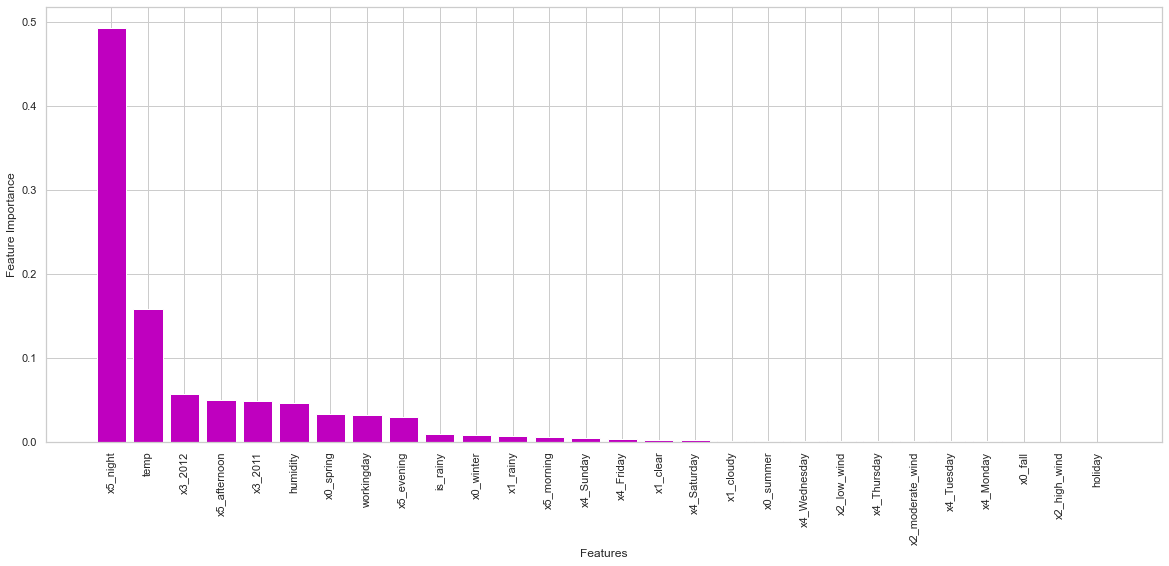

In [234]:
# taking a look at features importances according to RF model
# Create a pd.Series of features importances
importances = pd.Series(data=feature_importances,
                        index= feature_names_pipeline)

# Sort importances
importances_sorted = importances.sort_values(ascending=False)

# Draw barplot of importances_sorted

fig, ax = plt.subplots(figsize=(20,8))

ax.bar(importances_sorted.index, importances_sorted, color='m')
ax.set_xlabel("Features")
ax.set_ylabel("Feature Importance")
plt.xticks(rotation=90)

plt.show()

In [245]:
# attempting a gradient boosted regressor

gbr = GradientBoostingRegressor(n_estimators=200, max_depth=8, subsample=1)
pipeline_gbr = Pipeline([
     ('preprocessor', preprocessor),
     ('gbr', gbr)])
pipeline_gbr.fit(X_train, y_train)
y_pred = pipeline_gbr.predict(X_test)

print(r2_score(y_test, abs(y_pred)), r2_score(y_test, y_pred), np.sqrt(mean_squared_log_error(y_test, abs(y_pred))))

0.6693867981049662 0.6686471067208914 0.7855830023169916


## 6. Hyperparameter optimization


In [246]:
# so far the best performance was obtained by RF, so we will focus on tuning its parameters

rf = RandomForestRegressor()
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [252]:
params_dict = {'rf__max_depth': [None, 4, 6, 8, 10],
               'rf__n_estimators': [25, 50, 100, 200],
                'rf__max_features': ["auto", "sqrt", "log2"]}

rf = RandomForestRegressor()
pipeline_rf = Pipeline([
     ('preprocessor', preprocessor),
     ('rf', rf)])

grid_rf = GridSearchCV(estimator=pipeline_rf,
                       param_grid=params_dict,
                       scoring='neg_mean_squared_log_error',
                       cv=5,
                       n_jobs=-1)

grid_rf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         StandardScaler(),
                                                                         ['temp',
                                                                          'humidity']),
                                                                        ('categorical',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['season',
                                                                          'weather',
                                                                          'windspeed_binned',
                                                                          'year',
                                  

In [258]:
best_rf = grid_rf.best_estimator_
y_pred = best_rf.predict(X_test)
print(r2_score(y_test, y_pred), np.sqrt(mean_squared_log_error(y_test, y_pred)))
print(grid_rf.best_params_)
print(np.sqrt(-grid_rf.best_score_))

0.6880228205360359 0.7550080546860565
{'rf__max_depth': 10, 'rf__max_features': 'auto', 'rf__n_estimators': 100}
0.7859562149820274
